In [1]:
# Load, explore and plot data
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.layers import BatchNormalization, LayerNormalization

/var/folders/34/7y6hjt956tj2llwtmwrh9rb80000gn/T/ipykernel_16199/582975135.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-11 12:09:33.511818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data(dataset):
    data_path = {
        'train': './data/train_enc.tsv',
        'dev': './data/dev_enc.tsv',
        'test': './test_enc_unlabeled.tsv'
    }
    res = []
    if dataset in ['train','dev']:
        for x in open(data_path[dataset], encoding='utf-8'):
            x = x.rstrip('\n\r').split('\t')
            x[0] = int(x[0])
            res.append(x)
    elif dataset == 'test':
        for x in open(data_path[dataset], encoding='utf-8'):
            x = x.rstrip('\n\r')
            res.append(x)
    return res

In [3]:
train = load_data('train')
dev = load_data('dev')

In [4]:
train_labels = [x[0] for x in train]
train_texts = [x[1] for x in train]
dev_labels = [x[0] for x in dev]
dev_texts = [x[1] for x in dev]

In [5]:
print("Train size:", len(train_labels))
print("Dev size:", len(dev_labels))

Train size: 16220
Dev size: 2027


In [6]:
df = pd.DataFrame({"label": train_labels,
                   "text": train_texts})
df.head()

,label,text
0,0,lkêcê yoúc cêêö y#êjl lw mówám Újám j Úêê# ütl...
1,0,"6êcétlê jolêot8 zc éê#xw#öjóáê , tl zc j #jlkê..."
2,0,tx lktc kw8t6jú öw2tê tc coééwcê6 lw Úê j ytxl...
3,1,vocl ükêó úwo lktóm lkjl ê2ê#ú éwcctÚ8ê jóy8ê ...
4,1,yt2ê á#ê6tl lw ê2ê#úwóê x#wö #wÚtócwó 6wüó lw ...


In [7]:
df.groupby('label').describe().T

label                                                        0               1
text count                                                7999            8221
     unique                                               6835            6811
     top     x#t6jú jxlê# óê+l tc lkê mtó6 wx xt8ö lkjl áwo...  ükjl zc óê+l ?
     freq                                                    2               3

In [8]:
df[['text']].describe()

,text
count,16220
unique,13510
top,ükjl zc óê+l ?
freq,3


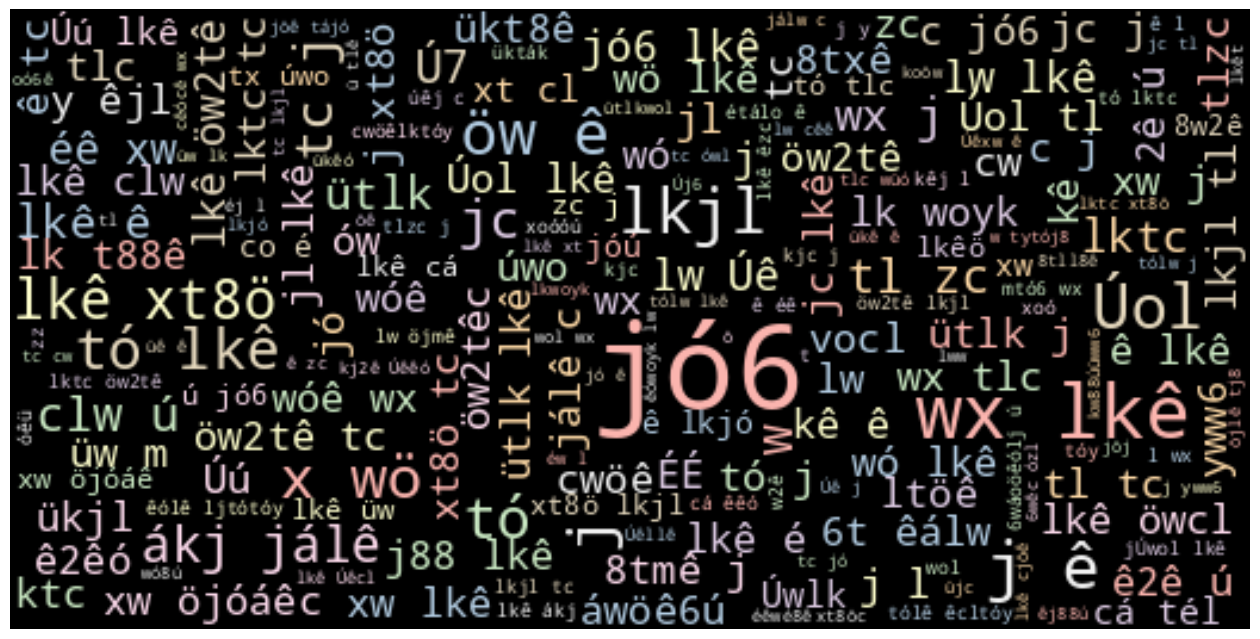

In [9]:
ham_msg_cloud = WordCloud(width=520, height=260, stopwords=STOPWORDS, 
                          max_font_size = 50, background_color = "black", 
                          colormap = 'Pastel1').generate(' '.join(train_texts))
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

In [22]:
df['len'] = df['text'].apply(lambda x: len(x.split()))

In [24]:
df['len'].describe()

count    16220.000000
mean        20.285265
std          9.370682
min          1.000000
25%         13.000000
50%         20.000000
75%         27.000000
max         56.000000
Name: len, dtype: float64

In [25]:
# Defining pre-processing parameters
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 20000

In [26]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(train_texts)

In [27]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

17416

In [28]:
training_sequences = tokenizer.texts_to_sequences(train_texts)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [29]:
testing_sequences = tokenizer.texts_to_sequences(dev_texts)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [30]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (16220, 50)
Shape of testing tensor:  (2027, 50)


In [31]:
train_label_matrix = tf.keras.utils.to_categorical(train_labels, num_classes=2)
dev_label_matrix = tf.keras.utils.to_categorical(dev_labels, num_classes=2)

In [26]:
# Define parameter
embedding_dim = 50
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [29]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath="./models/emb_mlp.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(training_padded, train_label_matrix,
                    validation_data=(testing_padded, dev_label_matrix),
                    batch_size=32, epochs=30, verbose=1, 
                    callbacks=[checkpointer])
model = tf.keras.models.load_model("./models/emb_mlp.keras")

train_score = model.evaluate(training_padded, train_label_matrix)
dev_score = model.evaluate(testing_padded, dev_label_matrix)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/30
507/507 [==============================] - 7s 13ms/step - loss: 0.0471 - accuracy: 0.9762 - val_loss: 0.9348 - val_accuracy: 0.8643
Epoch 2/30
507/507 [==============================] - 6s 12ms/step - loss: 0.0426 - accuracy: 0.9790 - val_loss: 0.9152 - val_accuracy: 0.8688
Epoch 3/30
507/507 [==============================] - 6s 12ms/step - loss: 0.0421 - accuracy: 0.9772 - val_loss: 1.0339 - val_accuracy: 0.8614
Epoch 4/30
507/507 [==============================] - 6s 11ms/step - loss: 0.0414 - accuracy: 0.9790 - val_loss: 1.0021 - val_accuracy: 0.8599
Epoch 5/30
507/507 [==============================] - 5s 10ms/step - loss: 0.0389 - accuracy: 0.9783 - val_loss: 1.0521 - val_accuracy: 0.8633
Epoch 6/30
507/507 [==============================] - 4s 8ms/step - loss: 0.0385 - accuracy: 0.9791 - val_loss: 1.1274 - val_accuracy: 0.8683
Epoch 7/30
507/507 [==============================] - 4s 8ms/step - loss: 0.0369 - accuracy: 0.9790 - val_loss: 1.1259 - val_accuracy: 0.8683
E

In [38]:
# Define parameter
embedding_dim = 100
n_lstm = 64
drop_lstm = 0.2
# Define LSTM Model 
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(n_lstm, dropout=0.2)))
model.add(Dense(64, kernel_initializer=tf.keras.initializers.he_normal(seed=0), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, kernel_initializer=tf.keras.initializers.he_normal(seed=0), activation='softmax'))
# Compile LSTM Model
learning_rate = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
# optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [39]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath="./models/lstm.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(training_padded, train_label_matrix,
                    validation_data=(testing_padded, dev_label_matrix),
                    batch_size=32, epochs=30, verbose=1, 
                    callbacks=[checkpointer])
model = tf.keras.models.load_model("./models/lstm.keras")

train_score = model.evaluate(training_padded, train_label_matrix, batch_size=32)
dev_score = model.evaluate(testing_padded, dev_label_matrix, batch_size=32)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/30
507/507 [==============================] - 79s 63ms/step - loss: 0.6938 - accuracy: 0.5049 - val_loss: 0.6925 - val_accuracy: 0.5402
Epoch 2/30
507/507 [==============================] - 33s 64ms/step - loss: 0.6928 - accuracy: 0.5130 - val_loss: 0.6937 - val_accuracy: 0.4810
Epoch 3/30
507/507 [==============================] - 32s 63ms/step - loss: 0.6908 - accuracy: 0.5257 - val_loss: 0.6892 - val_accuracy: 0.5348
Epoch 4/30
507/507 [==============================] - 34s 67ms/step - loss: 0.6849 - accuracy: 0.5518 - val_loss: 0.6756 - val_accuracy: 0.5797
Epoch 5/30
507/507 [==============================] - 34s 68ms/step - loss: 0.6739 - accuracy: 0.5761 - val_loss: 0.6536 - val_accuracy: 0.6088
Epoch 6/30
507/507 [==============================] - 41s 81ms/step - loss: 0.6496 - accuracy: 0.6247 - val_loss: 0.6355 - val_accuracy: 0.6265
Epoch 7/30
507/507 [==============================] - 58s 115ms/step - loss: 0.6172 - accuracy: 0.6606 - val_loss: 0.5895 - val_accuracy

In [40]:
history = model.fit(training_padded, train_label_matrix,
                    validation_data=(testing_padded, dev_label_matrix),
                    batch_size=32, epochs=100, verbose=1, initial_epoch=30,
                    callbacks=[checkpointer])
model = tf.keras.models.load_model("./models/lstm.keras")

train_score = model.evaluate(training_padded, train_label_matrix, batch_size=32)
dev_score = model.evaluate(testing_padded, dev_label_matrix, batch_size=32)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 31/100
507/507 [==============================] - 41s 75ms/step - loss: 0.1558 - accuracy: 0.9436 - val_loss: 0.4532 - val_accuracy: 0.8490
Epoch 32/100
507/507 [==============================] - 39s 76ms/step - loss: 0.1437 - accuracy: 0.9451 - val_loss: 0.4380 - val_accuracy: 0.8633
Epoch 33/100
507/507 [==============================] - 39s 78ms/step - loss: 0.1369 - accuracy: 0.9502 - val_loss: 0.4908 - val_accuracy: 0.8471
Epoch 34/100
507/507 [==============================] - 38s 74ms/step - loss: 0.1283 - accuracy: 0.9523 - val_loss: 0.5164 - val_accuracy: 0.8530
Epoch 35/100
507/507 [==============================] - 40s 79ms/step - loss: 0.1268 - accuracy: 0.9557 - val_loss: 0.5284 - val_accuracy: 0.8624
Epoch 36/100
507/507 [==============================] - 40s 79ms/step - loss: 0.1149 - accuracy: 0.9597 - val_loss: 0.4568 - val_accuracy: 0.8594
Epoch 37/100
507/507 [==============================] - 35s 69ms/step - loss: 0.1093 - accuracy: 0.9613 - val_loss: 0.5266 -

KeyboardInterrupt: 

In [ ]:
# Define parameter
embedding_dim = 100
n_lstm = 64
drop_lstm = 0.2
# Define LSTM Model 
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(n_lstm)))
model.add(Dropout(0.5))
# model.add(Dense(64, kernel_initializer=tf.keras.initializers.he_normal(seed=0), activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(2, kernel_initializer=tf.keras.initializers.he_normal(seed=0), activation='softmax'))
# Compile LSTM Model
learning_rate = 0.1
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
# optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath="./models/lstm.keras",
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

tf.random.set_seed(42)
history = model.fit(training_padded, train_label_matrix,
                    validation_data=(testing_padded, dev_label_matrix),
                    batch_size=32, epochs=50, verbose=1, 
                    callbacks=[checkpointer])
model = tf.keras.models.load_model("./models/lstm.keras")

train_score = model.evaluate(training_padded, train_label_matrix, batch_size=32)
dev_score = model.evaluate(testing_padded, dev_label_matrix, batch_size=32)

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("validation loss:", dev_score[0], "validation accuracy", dev_score[1])

Epoch 1/50
507/507 [==============================] - 43s 75ms/step - loss: 0.6942 - accuracy: 0.5031 - val_loss: 0.6913 - val_accuracy: 0.5397
Epoch 2/50
507/507 [==============================] - 39s 76ms/step - loss: 0.6910 - accuracy: 0.5223 - val_loss: 0.6890 - val_accuracy: 0.5387
Epoch 3/50
507/507 [==============================] - 38s 74ms/step - loss: 0.6846 - accuracy: 0.5504 - val_loss: 0.6800 - val_accuracy: 0.5644
Epoch 4/50
507/507 [==============================] - 36s 71ms/step - loss: 0.6701 - accuracy: 0.5829 - val_loss: 0.6513 - val_accuracy: 0.6236
Epoch 5/50
507/507 [==============================] - 43s 86ms/step - loss: 0.6474 - accuracy: 0.6195 - val_loss: 0.6202 - val_accuracy: 0.6497
Epoch 6/50
507/507 [==============================] - 42s 83ms/step - loss: 0.6118 - accuracy: 0.6653 - val_loss: 0.7920 - val_accuracy: 0.5683
Epoch 7/50
507/507 [==============================] - 38s 75ms/step - loss: 0.5784 - accuracy: 0.6968 - val_loss: 0.5679 - val_accuracy: